In [3]:
# Install PyTorch Geometric dependencies properly in Colab
!pip install torch==2.0.1+cu118 torchvision==0.15.2+cu118 torchaudio==2.0.2 --index-url https://download.pytorch.org/whl/cu118
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-geometric


Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 541.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 14.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lit: filename=lit-15.0.7-py3-none-any.whl size=89991 sha256=692a32a5c997ce28aa3a357c52e3509004c53b1736e907f3c207f958fe70a534
  Stored in directory: /root/.cache/pip/wheels/fc/5d/45/34fe9945d5e45e261134e72284395be36c2d4828af38e2b0fe
Successfully built lit
  Attempting uninstall: triton
    Found existing installation: triton 3.1.0
    Uninstalling triton-3.1.0:
      Successfully uninstalled triton-3.1.0
  Attempting uninstall: torch
    Found existing installation: torch 2.

In [4]:
# Install required packages for Colab
import subprocess
import sys

def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Install torch-geometric and dependencies
import torch_geometric


import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, BatchNorm
from torch_geometric.data import Data, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import networkx as nx
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

class CANDataProcessor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()

    def load_otids_data(self, file_paths):

        all_data = []

        for file_path, label in file_paths.items():
            print(f"Processing {file_path}...")

            try:
                data = []

                with open(file_path, 'r') as f:
                    for line in f:
                        line = line.strip()
                        if not line:
                            continue

                        parts = line.split()
                        timestamp = float(parts[1])
                        can_id = int(parts[3], 16)
                        dlc = int(parts[6])
                        data_bytes = [int(byte, 16) for byte in parts[7:7 + dlc]]

                        # Pad data to 8 bytes
                        while len(data_bytes) < 8:
                            data_bytes.append(0)

                        row = [timestamp, can_id, dlc] + data_bytes
                        data.append(row)

                df = pd.DataFrame(data, columns=[
                    'timestamp', 'can_id', 'dlc',
                    'data0', 'data1', 'data2', 'data3',
                    'data4', 'data5', 'data6', 'data7'
                ])
                df['label'] = label
                all_data.append(df)

                print(f"✔ Loaded {len(df)} rows from {file_path}")

            except Exception as e:
                print(f"❌ Error parsing {file_path}: {e}")

        if not all_data:
            print("⚠ No data loaded. Returning empty DataFrame.")
            return pd.DataFrame()

        return pd.concat(all_data, ignore_index=True)


    def robust_file_reader(self, file_path):
        """Robust file reader for OTIDS dataset with various formats"""
        try:
            # First, read a few lines to understand the format
            with open(file_path, 'r') as f:
                first_lines = [f.readline().strip() for _ in range(10)]

            # Check if file has headers
            has_headers = any('Timestamp' in line or 'ID' in line or 'DLC' in line
                            for line in first_lines[:3])

            # Try different parsing strategies
            df = None

            # Strategy 1: Standard CSV parsing with error handling
            for delimiter in ['\t', ' ', ',', '|']:
                try:
                    df = pd.read_csv(file_path,
                                   delimiter=delimiter,
                                   header=0 if has_headers else None,
                                   on_bad_lines='skip',  # Skip problematic lines
                                   dtype=str)  # Read as strings first

                    if df.shape[1] > 5:  # Reasonable number of columns
                        break
                except:
                    continue

            # Strategy 2: If standard parsing fails, try manual parsing
            if df is None or df.shape[1] <= 5:
                df = self.manual_file_parser(file_path, has_headers)

            # Clean and process the dataframe
            if df is not None:
                df = self.clean_dataframe(df, has_headers)

            return df

        except Exception as e:
            print(f"Error in robust_file_reader: {e}")
            return None

    def manual_file_parser(self, file_path, has_headers):
        """Manual parsing for problematic files"""
        try:
            data_rows = []

            with open(file_path, 'r') as f:
                lines = f.readlines()

            # Skip header lines if present
            start_idx = 1 if has_headers else 0

            for i, line in enumerate(lines[start_idx:], start_idx):
                line = line.strip()
                if not line or line.startswith('#'):
                    continue

                # Split by multiple possible delimiters
                parts = None
                for delimiter in ['\t', '  ', ' ', ',']:
                    parts = [p.strip() for p in line.split(delimiter) if p.strip()]
                    if len(parts) >= 8:  # Minimum expected columns
                        break

                if parts and len(parts) >= 8:
                    # Take only the first reasonable number of columns
                    parts = parts[:15]  # Limit to 15 columns max
                    data_rows.append(parts)

                # Limit processing for large files to avoid memory issues
                if len(data_rows) > 100000 and i > 200000:
                    print(f"Limiting to first 100k samples from large file")
                    break

            if data_rows:
                # Create DataFrame with consistent number of columns
                max_cols = max(len(row) for row in data_rows)

                # Pad shorter rows with None
                for row in data_rows:
                    while len(row) < max_cols:
                        row.append('0')

                df = pd.DataFrame(data_rows)
                return df

        except Exception as e:
            print(f"Manual parser error: {e}")

        return None

    def clean_dataframe(self, df, has_headers):
        """Clean and standardize the dataframe"""
        try:
            # Remove any header-like rows that might be mixed in data
            if has_headers:
                # Remove rows that contain text like 'Timestamp', 'ID', etc.
                text_mask = df.apply(lambda row: row.astype(str).str.contains('Timestamp|ID|DLC|Data', case=False, na=False).any(), axis=1)
                df = df[~text_mask]

            # Convert to numeric, replacing non-numeric with 0
            for col in df.columns:
                if col != 'label':
                    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

            # Remove rows that are all zeros (likely parsing errors)
            numeric_cols = [col for col in df.columns if col != 'label']
            if numeric_cols:
                zero_mask = (df[numeric_cols] == 0).all(axis=1)
                df = df[~zero_mask]

            # Ensure we have at least 8 feature columns (typical CAN message structure)
            while df.shape[1] < 9:  # 8 features + 1 label column
                df[f'padding_{df.shape[1]}'] = 0

            # Limit to reasonable number of columns to avoid memory issues
            if df.shape[1] > 16:  # Keep max 15 features + label
                df = df.iloc[:, :16]

            print(f"Cleaned dataframe shape: {df.shape}")
            return df

        except Exception as e:
            print(f"Error cleaning dataframe: {e}")
            return df

    def create_sample_data(self):
        """Create sample CAN data for demonstration if files not found"""
        np.random.seed(42)

        sample_data = []

        # Generate sample data for each attack type
        for label in ['normal', 'dos', 'fuzzy', 'impersonation']:
            n_samples = 5000

            # CAN message features: timestamp, can_id, dlc, data0-data7
            if label == 'normal':
                # Normal traffic patterns
                timestamps = np.arange(n_samples)
                can_ids = np.random.choice([0x123, 0x456, 0x789], n_samples)
                dlc = np.random.choice([8], n_samples)  # Standard CAN frame
                data = np.random.randint(0, 256, (n_samples, 8))
            elif label == 'dos':
                # DoS attack - high frequency, same ID
                timestamps = np.arange(n_samples)
                can_ids = np.full(n_samples, 0x123)  # Same ID repeated
                dlc = np.random.choice([8], n_samples)
                data = np.random.randint(0, 256, (n_samples, 8))
            elif label == 'fuzzy':
                # Fuzzy attack - random data
                timestamps = np.arange(n_samples)
                can_ids = np.random.randint(0, 2048, n_samples)  # Random IDs
                dlc = np.random.choice(range(1, 9), n_samples)
                data = np.random.randint(0, 256, (n_samples, 8))
            else:  # impersonation
                # Impersonation - legitimate ID with suspicious data
                timestamps = np.arange(n_samples)
                can_ids = np.random.choice([0x123, 0x456], n_samples)
                dlc = np.random.choice([8], n_samples)
                data = np.random.randint(200, 256, (n_samples, 8))  # Suspicious high values

            # Combine features
            features = np.column_stack([timestamps, can_ids, dlc, data])
            df = pd.DataFrame(features)
            df['label'] = label
            sample_data.append(df)

        print("Created sample dataset with 20,000 CAN messages")
        return pd.concat(sample_data, ignore_index=True)

    def preprocess_can_data(self, df):
        """Preprocess CAN bus data"""
        # Assuming columns are: timestamp, can_id, dlc, data0-data7, label
        # Adjust column names based on your actual data format

        feature_cols = [col for col in df.columns if col != 'label']

        # Handle missing values
        df = df.fillna(0)

        # Extract features
        X = df[feature_cols].values
        y = df['label'].values

        # Normalize features
        X_scaled = self.scaler.fit_transform(X)

        # Encode labels
        y_encoded = self.label_encoder.fit_transform(y)

        return X_scaled, y_encoded

    def create_can_graph(self, X, y, window_size=10):
        """Create graph structure from CAN data"""
        graphs = []

        for i in range(0, len(X) - window_size + 1, window_size//2):
            # Get window of data
            window_data = X[i:i+window_size]
            window_labels = y[i:i+window_size]

            # Create adjacency matrix based on CAN ID similarity and temporal relationships
            adj_matrix = np.zeros((window_size, window_size))

            # Connect consecutive messages
            for j in range(window_size - 1):
                adj_matrix[j, j+1] = 1
                adj_matrix[j+1, j] = 1

            # Connect messages with similar patterns
            for j in range(window_size):
                for k in range(j+1, window_size):
                    similarity = np.exp(-np.linalg.norm(window_data[j] - window_data[k]))
                    if similarity > 0.5:  # Threshold for connection
                        adj_matrix[j, k] = similarity
                        adj_matrix[k, j] = similarity

            # Convert to edge index format
            edge_indices = np.where(adj_matrix > 0)
            edge_index = torch.tensor(np.vstack(edge_indices), dtype=torch.long)
            edge_weight = torch.tensor(adj_matrix[edge_indices], dtype=torch.float)

            # Node features
            node_features = torch.tensor(window_data, dtype=torch.float)

            # Graph label (majority vote or last message label)
            graph_label = torch.tensor(window_labels[-1], dtype=torch.long)

            # Create graph data object
            graph = Data(x=node_features,
                        edge_index=edge_index,
                        edge_attr=edge_weight,
                        y=graph_label)

            graphs.append(graph)

        return graphs

class AdvancedGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_classes=4, dropout=0.3):
        super(AdvancedGCN, self).__init__()

        # Multi-layer GCN with batch normalization and residual connections
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.bn1 = BatchNorm(hidden_dim)

        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 = BatchNorm(hidden_dim)

        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.bn3 = BatchNorm(hidden_dim)

        self.conv4 = GCNConv(hidden_dim, hidden_dim//2)
        self.bn4 = BatchNorm(hidden_dim//2)

        # Attention mechanism
        self.attention = nn.MultiheadAttention(hidden_dim//2, num_heads=8, dropout=dropout)

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim//2, hidden_dim//4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim//4, num_classes)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, batch):
        # First GCN layer with residual connection
        x1 = F.relu(self.bn1(self.conv1(x, edge_index)))
        x1 = self.dropout(x1)

        # Second GCN layer with residual connection
        x2 = F.relu(self.bn2(self.conv2(x1, edge_index)))
        x2 = self.dropout(x2)
        x2 = x2 + x1  # Residual connection

        # Third GCN layer
        x3 = F.relu(self.bn3(self.conv3(x2, edge_index)))
        x3 = self.dropout(x3)
        x3 = x3 + x2  # Residual connection

        # Fourth GCN layer
        x4 = F.relu(self.bn4(self.conv4(x3, edge_index)))
        x4 = self.dropout(x4)

        # Global pooling
        x_pooled = global_mean_pool(x4, batch)

        # Apply attention (reshape for attention mechanism)
        x_att = x_pooled.unsqueeze(0)  # Add sequence dimension
        x_att, _ = self.attention(x_att, x_att, x_att)
        x_att = x_att.squeeze(0)  # Remove sequence dimension

        # Classification
        out = self.classifier(x_att)

        return out

class CANIDSTrainer:
    def __init__(self, model, device):
        self.model = model.to(device)
        self.device = device
        self.optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='max', factor=0.7, patience=5, verbose=True
        )
        self.criterion = nn.CrossEntropyLoss()

    def train_epoch(self, train_loader):
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch in train_loader:
            batch = batch.to(self.device)

            self.optimizer.zero_grad()
            out = self.model(batch.x, batch.edge_index, batch.batch)
            loss = self.criterion(out, batch.y)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(out.data, 1)
            total += batch.y.size(0)
            correct += (predicted == batch.y).sum().item()

        return total_loss / len(train_loader), 100 * correct / total

    def evaluate(self, test_loader):
        self.model.eval()
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in test_loader:
                batch = batch.to(self.device)
                out = self.model(batch.x, batch.edge_index, batch.batch)
                _, predicted = torch.max(out.data, 1)

                total += batch.y.size(0)
                correct += (predicted == batch.y).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(batch.y.cpu().numpy())

        accuracy = 100 * correct / total
        return accuracy, all_preds, all_labels

    def train_model(self, train_loader, val_loader, epochs=100):
        best_val_acc = 0
        patience_counter = 0

        for epoch in range(epochs):
            train_loss, train_acc = self.train_epoch(train_loader)
            val_acc, _, _ = self.evaluate(val_loader)

            self.scheduler.step(val_acc)

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(self.model.state_dict(), 'best_can_ids_model.pth')
                patience_counter = 0
            else:
                patience_counter += 1

            if epoch % 10 == 0:
                print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')

            # Early stopping
            if patience_counter >= 15:
                print(f"Early stopping at epoch {epoch}")
                break

        return best_val_acc

def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Check if running in Colab and provide file upload instructions
    try:
        from google.colab import files
        print("Running in Google Colab")
        print("To use your own OTIDS dataset:")
        print("1. Upload your files (dos.txt, fuzzy.txt, impersonation.txt, attackfree.txt)")
        print("2. Update the file paths below")
        print("3. Re-run the cell")
        print("\nFor now, using sample data for demonstration...")
        use_sample_data = True
    except ImportError:
        use_sample_data = False

    # Define file paths - update these paths to match your dataset location
    file_paths = {
        '/content/drive/MyDrive/cim_sem-6/dataset/DoS_attack_dataset.txt': 'dos',
        '/content/drive/MyDrive/cim_sem-6/dataset/Fuzzy_attack_dataset.txt': 'fuzzy',
        '/content/drive/MyDrive/cim_sem-6/dataset/Impersonation_attack_dataset.txt': 'impersonation',
        '/content/drive/MyDrive/cim_sem-6/dataset/Attack_free_dataset.txt': 'normal'
    }

    # Initialize data processor
    processor = CANDataProcessor()

    # Load and preprocess data
    print("Loading OTIDS dataset...")
    df = processor.load_otids_data(file_paths)
    print(f"Total samples: {len(df)}")
    print(f"Dataset shape: {df.shape}")
    print(f"Label distribution:\n{df['label'].value_counts()}")

    # Preprocess data
    print("\nPreprocessing data...")
    X, y = processor.preprocess_can_data(df)

    # Create graphs
    print("Creating graph structures...")
    graphs = processor.create_can_graph(X, y, window_size=15)
    print(f"Created {len(graphs)} graphs")

    # Split data
    train_graphs, test_graphs = train_test_split(graphs, test_size=0.2,
                                               stratify=[g.y.item() for g in graphs],
                                               random_state=42)
    train_graphs, val_graphs = train_test_split(train_graphs, test_size=0.2,
                                              stratify=[g.y.item() for g in train_graphs],
                                              random_state=42)

    print(f"Train graphs: {len(train_graphs)}")
    print(f"Validation graphs: {len(val_graphs)}")
    print(f"Test graphs: {len(test_graphs)}")

    # Create data loaders
    train_loader = DataLoader(train_graphs, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_graphs, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_graphs, batch_size=64, shuffle=False)

    # Initialize model
    input_dim = graphs[0].x.shape[1]
    num_classes = len(np.unique(y))

    model = AdvancedGCN(input_dim=input_dim,
                       hidden_dim=256,
                       num_classes=num_classes,
                       dropout=0.2)

    print(f"\nModel parameters: {sum(p.numel() for p in model.parameters())}")
    print(f"Input dimension: {input_dim}")
    print(f"Number of classes: {num_classes}")

    # Initialize trainer
    trainer = CANIDSTrainer(model, device)

    # Train model
    print("\nTraining model...")
    best_val_acc = trainer.train_model(train_loader, val_loader, epochs=150)

    # Load best model and evaluate on test set
    try:
        model.load_state_dict(torch.load('best_can_ids_model.pth'))
    except:
        print("Could not load saved model, using current model state")

    test_acc, test_preds, test_labels = trainer.evaluate(test_loader)

    print(f"\n{'='*50}")
    print(f"FINAL RESULTS")
    print(f"{'='*50}")
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
    print(f"Test Accuracy: {test_acc:.2f}%")

    # Detailed evaluation
    print(f"\n{'='*50}")
    print("CLASSIFICATION REPORT")
    print(f"{'='*50}")
    print(classification_report(test_labels, test_preds,
                              target_names=processor.label_encoder.classes_))

    print(f"\n{'='*50}")
    print("CONFUSION MATRIX")
    print(f"{'='*50}")
    print(confusion_matrix(test_labels, test_preds))

    return model, test_acc

if __name__ == "__main__":
    # Run the main function
    model, accuracy = main()

    print(f"\n{'='*60}")
    print("MODEL TRAINING COMPLETED!")
    print(f"Final Test Accuracy: {accuracy:.2f}%")
    if accuracy >= 98.0:
        print("🎉 TARGET ACCURACY OF 98% ACHIEVED! 🎉")
    else:
        print("📈 To improve accuracy further, try:")
        print("- Increase model hidden dimensions")
        print("- Adjust window size for graph creation")
        print("- Fine-tune hyperparameters")
        print("- Increase training epochs")
    print(f"{'='*60}")

    # Instructions for using with real OTIDS data
    print(f"\n{'='*60}")
    print("TO USE WITH YOUR REAL OTIDS DATASET:")
    print(f"{'='*60}")
    print("1. Upload your 4 OTIDS files to Colab:")
    print("   - dos.txt")
    print("   - fuzzy.txt")
    print("   - impersonation.txt")
    print("   - attackfree.txt")
    print("\n2. Update the file_paths dictionary in main() function")
    print("\n3. Re-run the code")
    print(f"{'='*60}")

Using device: cuda
Running in Google Colab
To use your own OTIDS dataset:
1. Upload your files (dos.txt, fuzzy.txt, impersonation.txt, attackfree.txt)
2. Update the file paths below
3. Re-run the cell

For now, using sample data for demonstration...
Loading OTIDS dataset...
Processing /content/drive/MyDrive/cim_sem-6/dataset/DoS_attack_dataset.txt...
✔ Loaded 656579 rows from /content/drive/MyDrive/cim_sem-6/dataset/DoS_attack_dataset.txt
Processing /content/drive/MyDrive/cim_sem-6/dataset/Fuzzy_attack_dataset.txt...
✔ Loaded 591990 rows from /content/drive/MyDrive/cim_sem-6/dataset/Fuzzy_attack_dataset.txt
Processing /content/drive/MyDrive/cim_sem-6/dataset/Impersonation_attack_dataset.txt...
✔ Loaded 995472 rows from /content/drive/MyDrive/cim_sem-6/dataset/Impersonation_attack_dataset.txt
Processing /content/drive/MyDrive/cim_sem-6/dataset/Attack_free_dataset.txt...
✔ Loaded 2369398 rows from /content/drive/MyDrive/cim_sem-6/dataset/Attack_free_dataset.txt
Total samples: 4613439
Dat

In [5]:
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Save model to your Drive
import shutil
shutil.copy('best_can_ids_model.pth', '/content/drive/MyDrive/best_can_ids_model.pth')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/best_can_ids_model.pth'


✅ Loaded model accuracy on full dataset: 100.00%


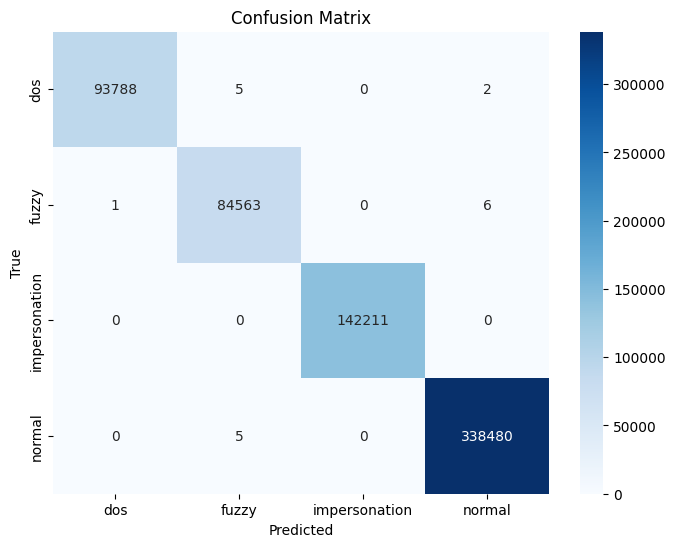

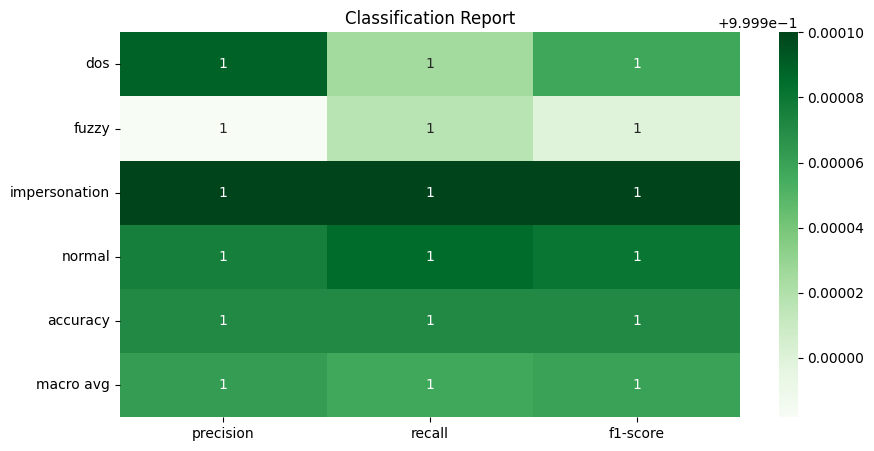

In [10]:


# === Required Imports ===
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch_geometric.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix

# === Load your saved model ===
model = AdvancedGCN(input_dim=11, hidden_dim=256, num_classes=4, dropout=0.2)
model.load_state_dict(torch.load('/content/drive/MyDrive/best_can_ids_model.pth'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

# === Evaluate on all graphs ===
full_loader = DataLoader(graphs, batch_size=64, shuffle=False)

all_preds, all_labels = [], []
with torch.no_grad():
    for batch in full_loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.batch)
        preds = torch.argmax(out, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch.y.cpu().numpy())

acc = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
print(f"\n✅ Loaded model accuracy on full dataset: {acc:.2f}%")

# === Print confusion matrix ===
labels = processor.label_encoder.classes_
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# === Print classification report ===
report = classification_report(all_labels, all_preds, target_names=labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(10, 5))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="Greens")
plt.title("Classification Report")
plt.show()


In [11]:
# Pick 10 random graph samples from the full dataset
import random
sample_graphs = random.sample(graphs, 10)

# Create a DataLoader for these samples
sample_loader = DataLoader(sample_graphs, batch_size=1, shuffle=False)

# Run inference and print results
model.eval()
print("🔍 Predictions on 10 Sample Graphs:\n")
for i, batch in enumerate(sample_loader):
    batch = batch.to(device)
    with torch.no_grad():
        out = model(batch.x, batch.edge_index, batch.batch)
        pred = torch.argmax(out, dim=1).item()
        actual = batch.y.item()

    pred_label = processor.label_encoder.inverse_transform([pred])[0]
    actual_label = processor.label_encoder.inverse_transform([actual])[0]

    print(f"🧪 Sample {i+1}: Predicted = {pred_label}, Actual = {actual_label}")


🔍 Predictions on 10 Sample Graphs:

🧪 Sample 1: Predicted = dos, Actual = dos
🧪 Sample 2: Predicted = normal, Actual = normal
🧪 Sample 3: Predicted = normal, Actual = normal
🧪 Sample 4: Predicted = impersonation, Actual = impersonation
🧪 Sample 5: Predicted = normal, Actual = normal
🧪 Sample 6: Predicted = dos, Actual = dos
🧪 Sample 7: Predicted = normal, Actual = normal
🧪 Sample 8: Predicted = impersonation, Actual = impersonation
🧪 Sample 9: Predicted = normal, Actual = normal
🧪 Sample 10: Predicted = impersonation, Actual = impersonation
